In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns

In [3]:
def calculate_technical_indicators(df):
    df = df.copy()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    delta = df['Adj Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    return df

In [4]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
stocks_data = {}
for ticker in tickers:
    print(f"Baixando dados para {ticker}...")
    data = yf.download(ticker, start="2017-01-01", end="2023-12-31")
    if 'Adj Close' in data.columns:
        data = calculate_technical_indicators(data)
        data.dropna(inplace=True)  
        stocks_data[ticker] = data
    else:
        print(f"Coluna 'Adj Close' não encontrada para {ticker}")

Baixando dados para AAPL...


[*********************100%***********************]  1 of 1 completed


Baixando dados para MSFT...


[*********************100%***********************]  1 of 1 completed


Baixando dados para GOOGL...


[*********************100%***********************]  1 of 1 completed


Baixando dados para AMZN...


[*********************100%***********************]  1 of 1 completed


Baixando dados para META...


[*********************100%***********************]  1 of 1 completed


In [5]:
fedfunds = pd.read_csv('/Users/pedrobueno/Desktop/Modelos ML/World Bank/FEDFUNDS.csv')
fedfunds['DATE'] = pd.to_datetime(fedfunds['DATE'])
fedfunds.set_index('DATE', inplace=True)

In [6]:
fedfunds = fedfunds.loc['2017-01-01':'2023-12-31']

In [7]:
fedfunds_daily = pd.DataFrame(index=pd.date_range(start='2017-01-01', end='2023-12-31'))
fedfunds_daily['FEDFUNDS'] = np.nan

In [8]:
for i, row in fedfunds.iterrows():
    start_date = i
    if i != fedfunds.index[-1]:
        end_date = fedfunds.index[fedfunds.index.get_loc(i) + 1] - pd.DateOffset(days=1)
    else:
        end_date = fedfunds_daily.index[-1]
    fedfunds_daily.loc[start_date:end_date, 'FEDFUNDS'] = row['FEDFUNDS']

In [9]:
file_path = '/Users/pedrobueno/Desktop/Modelos ML/World Bank/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3403845.csv'
df_pib = pd.read_csv(file_path, sep=';', skiprows=4)
df_pib_filtered = df_pib.loc[:, '2017':'2023']
df_pib_filtered = df_pib_filtered.T.reset_index()
df_pib_filtered.columns = ['Year', 'GDP']
df_pib_filtered['Date'] = pd.to_datetime(df_pib_filtered['Year'] + '-01-01')
df_pib_daily = pd.DataFrame(index=pd.date_range(start="2017-01-01", end="2024-01-01"))
df_pib_daily['GDP'] = np.nan

In [10]:
for i, row in df_pib_filtered.iterrows():
    start_date = row['Date']
    if i < len(df_pib_filtered) - 1:
        end_date = df_pib_filtered.loc[i + 1, 'Date'] - pd.DateOffset(days=1)
    else:
        end_date = pd.to_datetime('2024-01-01')
    df_pib_daily.loc[start_date:end_date, 'GDP'] = row['GDP']

In [11]:
X_train_all = pd.DataFrame()
y_train_all = pd.Series(dtype='float64')
X_test_all = pd.DataFrame()
y_test_all = pd.Series(dtype='float64')

In [12]:
for ticker in tickers:
    X = stocks_data[ticker].copy()

    # Definir o tamanho do treino
    train_size = int(len(X) * 0.8)
    
    # Criar X_train e X_test
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    
    # PIB
    X_train = X_train.join(df_pib_daily['GDP'], how='left')
    X_test = X_test.join(df_pib_daily['GDP'], how='left')
    
    # Taxa de juros
    X_train = X_train.join(fedfunds_daily['FEDFUNDS'], how='left')
    X_test = X_test.join(fedfunds_daily['FEDFUNDS'], how='left')
    
    # Criar y_train e y_test com base em Adj Close deslocado
    y_train = X_train['Adj Close'].shift(-1)  # Prever o próximo dia
    y_test = X_test['Adj Close'].shift(-1)  # Prever o próximo dia
    
    # Remover NaNs do conjunto de treino e teste
    X_train.dropna(inplace=True)
    y_train.dropna(inplace=True)
    
    # Ajustar os tamanhos de X_train e y_train para garantir correspondência de índices
    min_len_train = min(len(X_train), len(y_train))
    X_train = X_train.iloc[:min_len_train]
    y_train = y_train.iloc[:min_len_train]

    # Ajustar os tamanhos de X_test e y_test para garantir correspondência de índices
    min_len_test = min(len(X_test), len(y_test))
    X_test = X_test.iloc[:min_len_test]
    y_test = y_test.iloc[:min_len_test]
    
    X_train_all = pd.concat([X_train_all, X_train])
    y_train_all = pd.concat([y_train_all, y_train])
    X_test_all = pd.concat([X_test_all, X_test])
    y_test_all = pd.concat([y_test_all, y_test])

In [13]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'SMA_20', 'SMA_50', 'RSI', 'EMA_20', 'FEDFUNDS']
X_train_all = X_train_all[features]
X_test_all = X_test_all[features]

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_all)  
X_test_scaled = scaler.transform(X_test_all)

In [15]:
ridge_model = Ridge(alpha=10.0) 
ridge_model.fit(X_train_scaled, y_train_all)

Ridge(alpha=10.0)

In [16]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_all)

LinearRegression()

In [17]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [18]:
y_test_all = y_test_all.dropna()
y_pred_test = pd.Series(y_pred_test).dropna()

In [19]:
mse_train = mean_squared_error(y_train_all, y_pred_train)
mae_train = mean_absolute_error(y_train_all, y_pred_train)
r2_train = r2_score(y_train_all, y_pred_train)

In [20]:
min_len_test = min(len(y_test_all), len(y_pred_test))
y_test_all = y_test_all.iloc[:min_len_test]
y_pred_test = y_pred_test[:min_len_test]

In [21]:
mse_test = mean_squared_error(y_test_all, y_pred_test)
mae_test = mean_absolute_error(y_test_all, y_pred_test)
r2_test = r2_score(y_test_all, y_pred_test)

print(f"Train - Mean Squared Error: {mse_train}")
print(f"Train - Mean Absolute Error: {mae_train}")
print(f"Train - R2 Score: {r2_train}")

print(f"Test - Mean Squared Error: {mse_test}")
print(f"Test - Mean Absolute Error: {mae_test}")
print(f"Test - R2 Score: {r2_test}")

Train - Mean Squared Error: 13.436362150234546
Train - Mean Absolute Error: 2.3966870076260824
Train - R2 Score: 0.9976963186847787
Test - Mean Squared Error: 140.69375572477776
Test - Mean Absolute Error: 5.625463833555592
Test - R2 Score: 0.9786281521412985


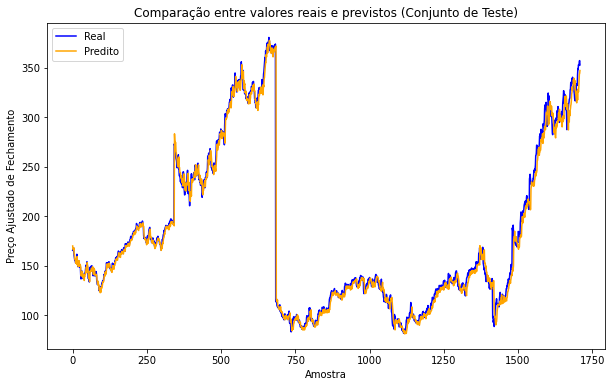

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_all.values, label='Real', color='blue')
plt.plot(y_pred_test, label='Predito', color='orange')
plt.title('Comparação entre valores reais e previstos (Conjunto de Teste)')
plt.xlabel('Amostra')
plt.ylabel('Preço Ajustado de Fechamento')
plt.legend()
plt.show()

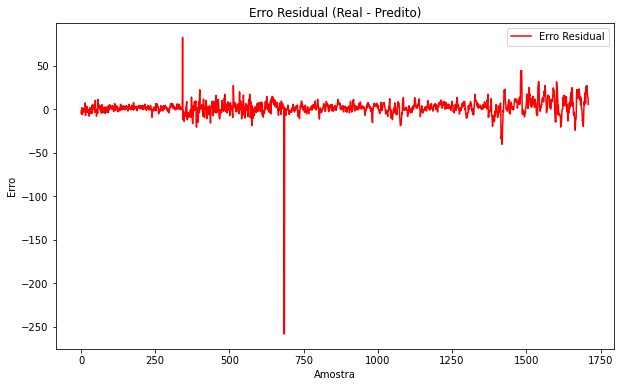

In [23]:
residuals = y_test_all.values - y_pred_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Erro Residual', color='red')
plt.title('Erro Residual (Real - Predito)')
plt.xlabel('Amostra')
plt.ylabel('Erro')
plt.legend()
plt.show()

In [24]:
correlation_matrix = X_train_all.corr()

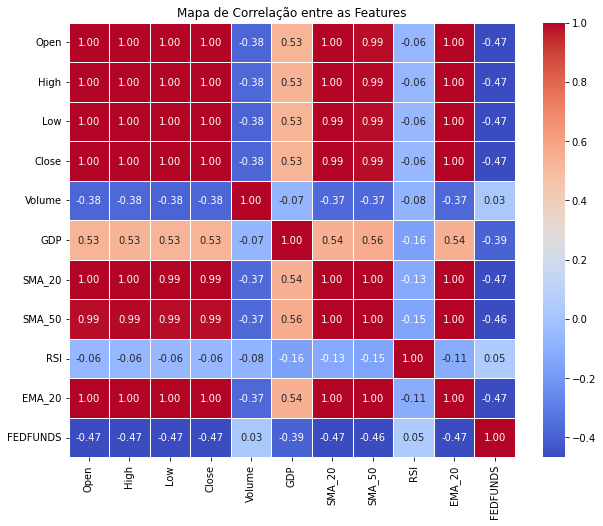

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação entre as Features')
plt.show()